In [88]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score
from scipy import sparse
import pickle

print(tf.__version__)

1.12.0


In [100]:
## Import Data
GENRES_IDX = {"blues":0, "gospel":1, "rap":2, "country":3, "rock":4}
GENRE_NAMES = ["blues", "gospel", "rap", "country", "rock"]

NON_SPARSE_FEATS = ['n_wrds', 'avg_wrd_len',
       'n_lines', 'avg_line_len', 'n_contractions', 'contraction_density',
       'vocab_size', 'edge_density',
       'edge_density_weighted', 'edge_weight_var', 'degree_var',
       'degree_var_weighted', 'degree_avg', 'degree_avg_weighted',
       'comp_size_avg', 'lz_comp_ratio']

SPARSE_FEATS = ['word2vec_avg', 'topk']

SPARSE_FEATS = ['topk']
NON_SPARSE_FEATS = ['n_wrds', 'avg_wrd_len',
       'n_lines', 'avg_line_len', 'n_contractions', 'contraction_density',
       'vocab_size']


N_NONSPARSE = len(NON_SPARSE_FEATS)
N_SPARSE = len(SPARSE_FEATS)

def df_to_arr(df):
    x = df[NON_SPARSE_FEATS]
    x_arr = x.values
    
    if N_SPARSE > 0:
        y_arr_list = []
        for sparse_feat in SPARSE_FEATS:
            y = df[sparse_feat]
            y_list = [list(y.values[i]) for i in range(y.values.shape[0])]
            y_arr = np.array(y_list)
            y_arr_list.append(y_arr)

        y_arr = y_arr_list[0]
        for i in range(len(y_arr_list) - 1):
            y_arr = np.concatenate((y_arr, y_arr_list[i+1]), axis=1)
    
    # Use one hot encoding labels
    kron = np.eye(5)
    labels = df["genre"].values
    labels_one_hot = np.array([kron[:, GENRES_IDX[genre]] for genre in labels])
    
    # Use integer labels
    labels_sparse = np.array([GENRES_IDX[genre] for genre in labels])
    
    if N_SPARSE > 0:
        data = np.concatenate((x_arr, y_arr), axis=1)
    else:
        data = x_arr
    return data, labels_sparse

def read_data(fn):
    df = pd.read_pickle(fn)
    df.fillna(0, inplace=True)
    df_train = df.query("data_split == 'train'").copy()
    df_test = df.query("data_split == 'test'").copy()
    df_val = df.query("data_split == 'val'").copy()

    lyrics_train = np.array(df_train["lyrics_stripped"].values)
    lyrics_test = np.array(df_test["lyrics_stripped"].values)
    lyrics_val = np.array(df_val["lyrics_stripped"].values)

    X_train, Y_train = df_to_arr(df_train)
    X_val, Y_val = df_to_arr(df_val)
    X_test, Y_test = df_to_arr(df_test)
        
    if N_NONSPARSE > 0:
        ## Standardize Data
        scaler = preprocessing.StandardScaler().fit(X_train[:, :N_NONSPARSE])
        X_train[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_train[:, :N_NONSPARSE])
        X_val[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_val[:, :N_NONSPARSE])
        X_test[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_test[:, :N_NONSPARSE])
    if N_SPARSE > 0:
        scaler_sparse = preprocessing.MinMaxScaler().fit(X_train[:, N_NONSPARSE:])
        X_train[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_train[:, N_NONSPARSE:])
        X_val[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_val[:, N_NONSPARSE:])
        X_test[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_test[:, N_NONSPARSE:])
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test, lyrics_train, lyrics_val, lyrics_test

ALL_DATA_FN = "all.data"
X_train, Y_train, X_val, Y_val, X_test, Y_test,  lyrics_train, lyrics_val, lyrics_test = read_data(ALL_DATA_FN)
DIM = X_train.shape[1]

In [111]:
# Shuffle X_train and Y_train

N = X_train.shape[0]
idx = np.array([i for i in range(N)])
np.random.shuffle(idx)
X_train = X_train[idx]
Y_train = Y_train[idx]

(35380, 7912)


In [102]:
# Calculate the gradients of each output node w.r.t. each input feature

inputs = tf.keras.Input(shape=(DIM,))  # Returns a placeholder tensor

# A layer instance is callable on a tensor, and returns a tensor.
x = keras.layers.Dense(200, activation=tf.nn.relu)(inputs)
# x = inputs # For single layer neural network

predictions = keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

model.fit(X_train, Y_train,
          epochs=100,
          validation_data = (X_val, Y_val), 
          batch_size=32,
          callbacks=callbacks
         )

# Evaluate Model
model.evaluate(X_test, Y_test, batch_size=32)

Train on 35380 samples, validate on 11851 samples
Epoch 1/100
35380/35380 [==============================] - 9s 264us/step - loss: 0.8307 - acc: 0.6803 - val_loss: 0.7356 - val_acc: 0.7156
Epoch 2/100
35380/35380 [==============================] - 9s 268us/step - loss: 0.5547 - acc: 0.7892 - val_loss: 0.7727 - val_acc: 0.7099
Epoch 3/100
11730/11730 [==============================] - 2s 133us/step


[0.8389582218524491, 0.7058823529005254]

In [103]:
def save_weights():
    df = pd.DataFrame(model.get_weights()[0])
    df.loc["bias", :] = model.get_weights()[1]

    with open('topk_vocab', 'rb') as fp:
        vocab = pickle.load(fp)

    feats = NON_SPARSE_FEATS + ["dim" + str(i) for i in range(100)] + vocab + ["bias"]
    df["feats"] = feats
    print(df)
    df.to_csv("weights.csv")

SAVE_WEIGHTS = False
if SAVE_WEIGHTS:
    save_weights()

In [104]:
X = X_test
Y = Y_test
lyrics = lyrics_test

Y_hat = model.predict(X)
Y_pred = np.argmax(Y_hat, axis=1)

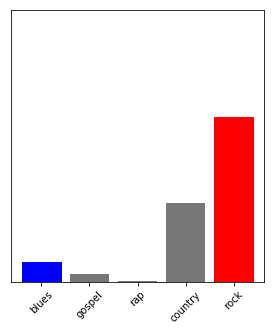

In [105]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    
i = 500
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_value_array(i, Y_hat,  Y)
_ = plt.xticks(range(5), GENRE_NAMES, rotation=45)

Confusion matrix, without normalization
[[ 767   35   11  195  379]
 [  42 1224   50  238  228]
 [  17   33 1995   21   92]
 [ 244  185   29 2144  646]
 [ 299  152   65  489 2150]]
Normalized confusion matrix
[[0.55 0.03 0.01 0.14 0.27]
 [0.02 0.69 0.03 0.13 0.13]
 [0.01 0.02 0.92 0.01 0.04]
 [0.08 0.06 0.01 0.66 0.2 ]
 [0.09 0.05 0.02 0.15 0.68]]


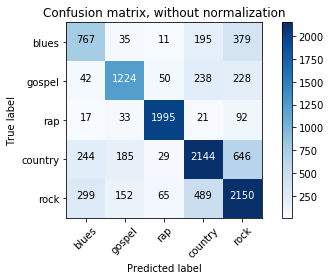

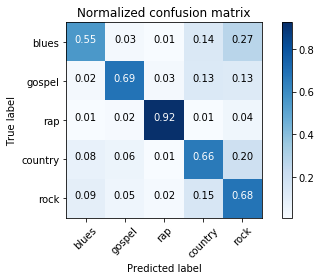

F1 Scores:
['blues', 'gospel', 'rap', 'country', 'rock']


array([0.56, 0.72, 0.93, 0.68, 0.65])

In [106]:
### DISPLAY PERFORMANCE STATISTICS

## Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(Y, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=GENRE_NAMES,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=GENRE_NAMES, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Print F1 Scores
print("F1 Scores:")
print(GENRE_NAMES)
f1_score(Y, Y_pred, average=None)


In [107]:
# Calculate Gradients
def calculate_gradients():
    output_tens = predictions
    input_tens = inputs

    grad = [tf.gradients(output_tens[i], input_tens) for i in range(output_tens.shape[1])]

    sess = tf.keras.backend.get_session()
    grad_val = np.squeeze(np.array(sess.run(grad, feed_dict={input_tens: X})))
    return grad_val

CALCULATE_GRADS = False
if CALCULATE_GRADS:
    grad_val = calculate_gradients()

In [108]:
def get_activations(label_true, label_pred):
    pred_idx = set(np.squeeze(np.argwhere(Y_pred == GENRES_IDX[label_pred])))
    true_idx = set(np.squeeze(np.argwhere(Y == GENRES_IDX[label_true])))
    target_idx = pred_idx.intersection(true_idx)
    return target_idx, np.average(grad_val[:, list(target_idx), :], axis=1)

def get_lyrics(label_true, label_pred):
    pred_idx = set(np.squeeze(np.argwhere(Y_pred == GENRES_IDX[label_pred])))
    true_idx = set(np.squeeze(np.argwhere(Y == GENRES_IDX[label_true])))
    target_idx = list(pred_idx.intersection(true_idx))
    return lyrics[target_idx]

EXAMINE_ACTIVATIONS = False
if EXAMINE_ACTIVATIONS:
    label_true = "rock"
    label_pred = "blues"
    for label_true in GENRE_NAMES:
        for label_pred in GENRE_NAMES:
            print("True label: "+ label_true)
            print("Predicted label: "+ label_pred)
            target_idx, activations = get_activations(label_true, label_pred)
            print(sparse.csr_matrix(activations))

EXAMINE_LYRICS = False
if EXAMINE_LYRICS:
    label_true = "blues"
    label_pred = "rock"
    lyrics_target = get_lyrics(label_true, label_pred)
    print(len(lyrics_target))
    print(lyrics_target[0])



In [109]:
def get_derivative(x, eps = 1e-10):
    y = model.predict(x)
    h = 10
    dy_old = np.array([0]*5)
    dy_new = np.array([100]*5)
    while(max(abs(dy_old - dy_new)) > eps):
        dx = np.zeros_like(x)
        dx[0] = h
        x2 = x + dx
        y2 = model.predict(np.array(x2))
        dy_new = (y[0] - y2[0])/h
        h = h/2
#         print(dy_new)
    return dy_new

CALCULATE_DERIVATIVES = False
if CALCULATE_DERIVATIVES:
    for i in range(X.shape[1]):
        eps = 1e-10
        x = np.array([X[i]])
        dy = get_derivative(x)
        if(max(abs(dy)) > eps):
            print(dy)